In [1]:
import glob
import pandas as pd
import torch
import seaborn as sns
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## create dataframe of train/test/val

In [2]:
data_path = '/cluster/home/taheeraa/datasets/chestxray-14'


labels = [
    "Atelectasis", 
    "Cardiomegaly",
    "Effusion", 
    "Infiltration", 
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",  
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia"
]
    
file_path_train = data_path + '/train_official.txt'
file_path_val = data_path + '/val_official.txt'
file_path_test = data_path + '/test_official.txt'

columns = ['Image Filename'] + labels

df_train = pd.read_csv(file_path_train, sep='\s+', names=columns)
df_val = pd.read_csv(file_path_val, sep='\s+', names=columns)
df_test = pd.read_csv(file_path_test, sep='\s+', names=columns)

df_train

,Image Filename,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000004_000.png,0,0,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75307,00030789_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0
75308,00030793_000.png,0,0,0,0,1,1,0,0,0,0,0,0,0,0
75309,00030795_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0
75310,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## find subfolders in dataset

In [3]:
subfolders = [f"images_{i:03}/images" for i in range(1, 13)]  # Generates 'images_001' to 'images_012'
subfolders

['images_001/images',
 'images_002/images',
 'images_003/images',
 'images_004/images',
 'images_005/images',
 'images_006/images',
 'images_007/images',
 'images_008/images',
 'images_009/images',
 'images_010/images',
 'images_011/images',
 'images_012/images']

## create full image path

The dataset needs the full path to the images, and they are placed in different folders. Therefore we need to create `path_mappings` to map an image_file to a image_path. This is used to create `Full Image Path`

In [4]:
path_mapping = {}

for subfolder in subfolders:
    full_folder_path = os.path.join(data_path, subfolder)
    for img_file in os.listdir(full_folder_path):
        path_mapping[img_file] = os.path.join(full_folder_path, img_file)

df_train['Full Image Path'] = df_train['Image Filename'].map(path_mapping)
df_val['Full Image Path'] = df_val['Image Filename'].map(path_mapping)
df_test['Full Image Path'] = df_test['Image Filename'].map(path_mapping)

# Move 'Full Image Path' to the front of the DataFrame
cols_train = ['Full Image Path'] + [col for col in df_train.columns if col != 'Full Image Path']
cols_val = ['Full Image Path'] + [col for col in df_val.columns if col != 'Full Image Path']
cols_test = ['Full Image Path'] + [col for col in df_test.columns if col != 'Full Image Path']

df_train = df_train[cols_train]
df_val = df_val[cols_val]
df_test = df_test[cols_test]

df_train = df_train.drop(columns=['Image Filename'])
df_val = df_val.drop(columns=['Image Filename'])
df_test = df_test.drop(columns=['Image Filename'])

df_train

,Full Image Path,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75307,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
75308,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,1,1,0,0,0,0,0,0,0,0
75309,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
75310,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
print(f"Train dataframe shape: {df_train.shape} (1 size larger than expected due to 'Full Image Path')")
print(f"Train columns: {df_train.columns}")
print(f"Labels: {labels}")
print(f"Num labels: {len(labels)}")

Train dataframe shape: (75312, 15) (1 size larger than expected due to 'Full Image Path')
Train columns: Index(['Full Image Path', 'Atelectasis', 'Cardiomegaly', 'Effusion',
       'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
       'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening',
       'Hernia'],
      dtype='object')
Labels: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
Num labels: 14


## look at train/val/test split

/tmp/ipykernel_756564/1405138564.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataframe', y='Percentage', data=plot_df, palette=custom_palette)


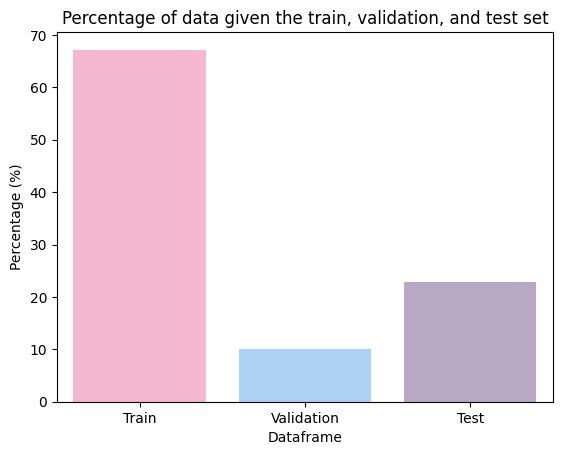

In [6]:
train_count = len(df_train)
val_count = len(df_val)
test_count = len(df_test)

total_rows = train_count + val_count + test_count
train_percentage = (train_count / total_rows) * 100
val_percentage = (val_count / total_rows) * 100
test_percentage = (test_count / total_rows) * 100

plot_df = pd.DataFrame({
    'Dataframe': ['Train', 'Validation', 'Test'],
    'Percentage': [train_percentage, val_percentage, test_percentage]
})

custom_palette = ['#FFAFCC', '#A2D2FF', '#BAA4C7']  # Pink, Blue, Purple

sns.barplot(x='Dataframe', y='Percentage', data=plot_df, palette=custom_palette)
plt.title('Percentage of data given the train, validation, and test set')
plt.ylabel('Percentage (%)')
plt.savefig("images/percentage_data_train_val_test.png")

In [7]:
data = [
    ["Train", f"{train_count:,}", f"~{train_percentage}%"],
    ["Validation", f"{val_count:,}", f"~{val_percentage}%"],
    ["Test", f"{test_count:,}", f"~{test_percentage}%"]
]

table = tabulate(data, headers=["Set", "Number of Samples", "Percent"], tablefmt="grid")
print(table)

+------------+---------------------+----------------------+
| Set        | Number of Samples   | Percent              |
+============+=====================+======================+
| Train      | 75,312              | ~67.17088833392793%  |
+------------+---------------------+----------------------+
| Validation | 11,212              | ~10.0%               |
+------------+---------------------+----------------------+
| Test       | 25,596              | ~22.829111666072066% |
+------------+---------------------+----------------------+


In [8]:
total_counts = df_train[labels].sum() + df_val[labels].sum() + df_test[labels].sum()

total_samples = len(df_train) + len(df_val) + len(df_test)

percentages = (total_counts / total_samples) * 100
data = [(label, f"{int(total_counts[label]):,}", f"~{int(percentages[label])}%") for label in labels]

table = tabulate(data, headers=["Pathology", "Number of Samples", "Percent"], tablefmt="grid")
print(table)

+--------------------+---------------------+-----------+
| Pathology          | Number of Samples   | Percent   |
+====================+=====================+===========+
| Atelectasis        | 11,559              | ~10%      |
+--------------------+---------------------+-----------+
| Cardiomegaly       | 2,776               | ~2%       |
+--------------------+---------------------+-----------+
| Effusion           | 13,317              | ~11%      |
+--------------------+---------------------+-----------+
| Infiltration       | 19,894              | ~17%      |
+--------------------+---------------------+-----------+
| Mass               | 5,782               | ~5%       |
+--------------------+---------------------+-----------+
| Nodule             | 6,331               | ~5%       |
+--------------------+---------------------+-----------+
| Pneumonia          | 1,431               | ~1%       |
+--------------------+---------------------+-----------+
| Pneumothorax       | 5,302   

/tmp/ipykernel_756564/2695836251.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_summary.values, y=label_summary.index, palette=colors)
/tmp/ipykernel_756564/2695836251.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=label_summary.values, y=label_summary.index, palette=colors)


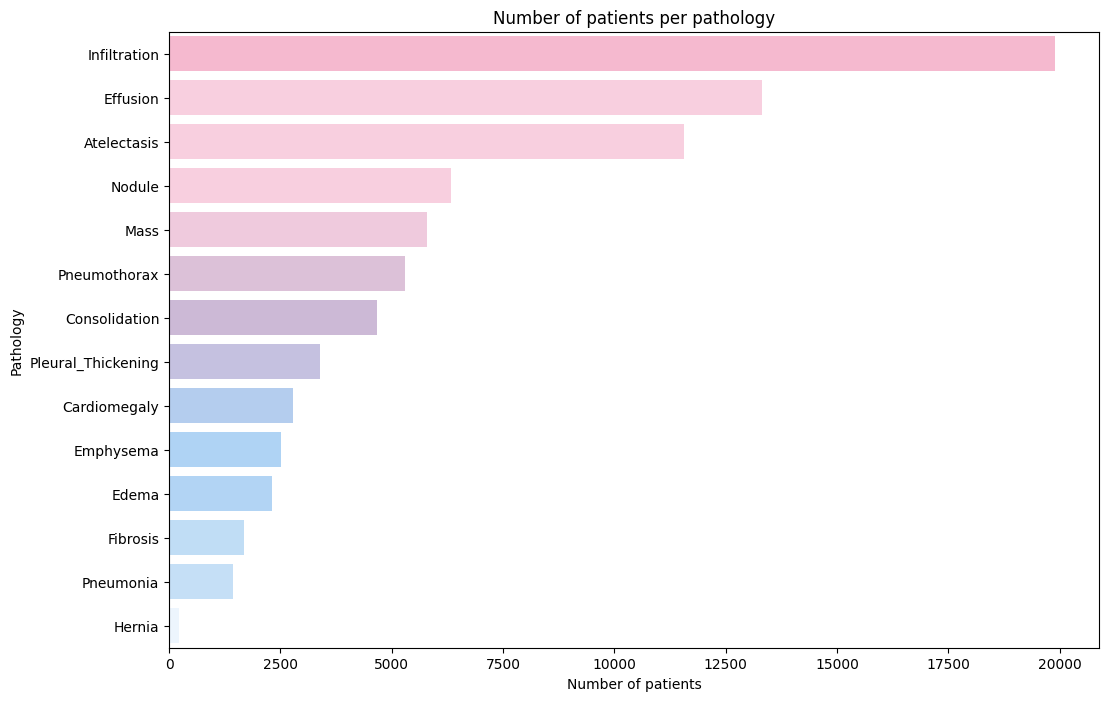

In [9]:
combined_df = pd.concat([df_train, df_val, df_test])
label_summary = combined_df.iloc[:, 1:].sum().sort_values()[::-1]

custom_colors = ["#FFAFCC", "#FFAFCC", "#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD", "#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD", "#CDB4DB","#CDB4DB", "#A2D2FF", "#BDE0FE","#EBF5FF"]

custom_colors = custom_colors[::-1]  # Reverse the color order
cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors, N=256)
norm = plt.Normalize(label_summary.values.min(), label_summary.values.max())
colors = cmap(norm(label_summary.values))

# Create the barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=label_summary.values, y=label_summary.index, palette=colors)
plt.xlabel('Number of patients')
plt.ylabel('Pathology')
plt.title('Number of patients per pathology')
plt.savefig('images/no-patients-per-disease.png')


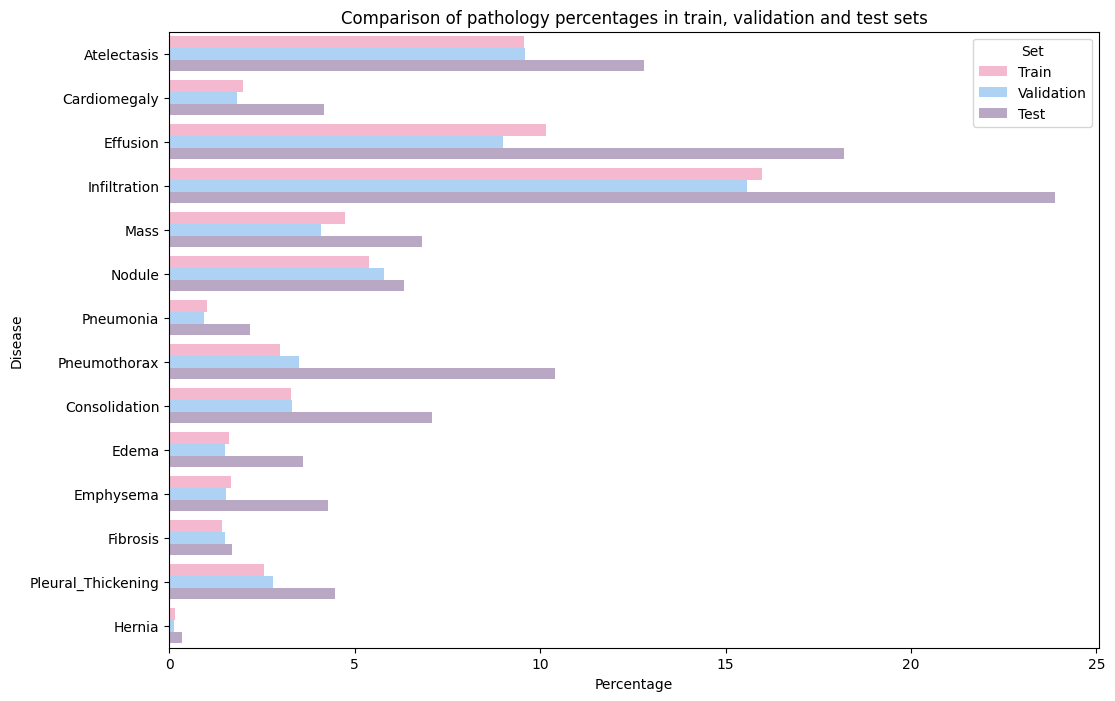

In [12]:
train_percentages = df_train[labels].mean() * 100
val_percentages = df_val[labels].mean() * 100
test_percentage = df_test[labels].mean() * 100

# create a DataFrame that contains the calculated percentages
data = {
    'Train': train_percentages,
    'Validation': val_percentages,
    'Test': test_percentage
}

percentage_df = pd.DataFrame(data)

# reset index to make 'Disease' a column
percentage_df = percentage_df.reset_index().rename(
    columns={'index': 'Disease'})

# melt the DataFrame from wide format to long format for plotting
percentage_df = percentage_df.melt(
    id_vars='Disease', var_name='Set', value_name='Percentage')

# create a bar plot that compares the percentages of each disease in the train and validation sets
plt.figure(figsize=(12, 8))
sns.barplot(data=percentage_df, x='Percentage',
            y='Disease', hue='Set', alpha=1, palette=custom_palette)
plt.title('Comparison of pathology percentages in train, validation and test sets')
plt.savefig("images/percentage_train_val_test.png")